## Task 1: Theory (3pt)

1. Let's recall the variational lower bound for the discrete data dequantization problem from Lecture 7:
$$
    \log P(\mathbf{x} | \boldsymbol{\theta}) \geq  \int q(\mathbf{u} | \mathbf{x}) \log \frac{p(\mathbf{x} + \mathbf{u} | \boldsymbol{\theta})}{q(\mathbf{u} | \mathbf{x})} d \mathbf{u} = \mathcal{L}(q, \boldsymbol{\theta}).
$$
We have discussed with you that the variational lower bound can be improved with the help of Importance Sampling technique. Write out the lower bound for dequantization using $\mathcal{L}_k$ by analogy with the IWAE model (you need to use not just one $\mathbf{u}$, but a set of $\{\mathbf{u}_k\}_{k=1}^K$).
    
2. The Vanilla GAN often suffers from problems with a vanishing gradient. [Least Squares GAN](https://arxiv.org/abs/1611.04076) tries to solve this problem by replacing the error function with the following:
$$
   	\min_D V(D) = \min_D \frac{1}{2}\left[ \mathbb{E}_{\pi(\mathbf{x})} (D(\mathbf{x}) - b)^2 + \mathbb{E}_{p(\mathbf{z})} (D(G(\mathbf{z})) - a)^2 \right]
$$
$$
   	\min_G V(G) = \min_G \frac{1}{2}\left[ \mathbb{E}_{\pi(\mathbf{x})} (D(\mathbf{x}) - c)^2 + \mathbb{E}_{p(\mathbf{z})} (D(G(\mathbf{z})) - c)^2 \right],
$$
where $a,b,c \in \mathbb{R}$ some fixed constants.
    * Find the formula for the optimal discriminator $D^*$.
    * Write out the expression for the error function of the generator $V(G)$ in the case of an optimal discriminator $D^*$.
    * Prove that for $b - c = 1$, $b - a = 2$, the error function of the generator $V(G)$ in the case of the optimal discriminator $D^*$ takes the form:
$$
   	V(G) = \frac{1}{2} \chi^2_{\text{Pearson}} (\pi(\mathbf{x}) + p(\mathbf{x} | \boldsymbol{\theta}) || 2 p(\mathbf{x} | \boldsymbol{\theta})), 
$$
where $\chi^2_{\text{Pearson}} (p || q)$ is a squared Pearson divergence:
$$
   	\chi^2_{\text{Pearson}} (p || q) = \int \frac{(p(\mathbf{x}) - q(\mathbf{x}))^2}{p(\mathbf{x})} d \mathbf{x}.
$$

1.
$$
\log P(\mathbf{x} | \boldsymbol{\theta}) = \log  \mathbb{E}_{q(\mathbf{u} | \mathbf{x})} \frac{p(\mathbf{x} + \mathbf{u} | \boldsymbol{\theta})}{q(\mathbf{u} | \mathbf{x})} = \log \frac{1}{K} \sum_{k=1}^{K} \frac{p(\mathbf{x} + \mathbf{u_k} | \boldsymbol{\theta})}{q(\mathbf{u_k} | \mathbf{x})}
$$
, where $u_k \sim {q(\mathbf{u_k} | \mathbf{x})}$


2. 
$$
   	\min_D V(D) = \min_D \frac{1}{2}\left[ \mathbb{E}_{p_r(\mathbf{x})} (D(\mathbf{x}) - b)^2 + \mathbb{E}_{p_g(\mathbf{z})} (D(x) - a)^2 \right] = \frac{1}{2} \int \left[ {p_r(\mathbf{x})} (D(\mathbf{x}) - b)^2 + {p_g(\mathbf{z})} (D(x) - a)^2 \right]  dx
$$

* 
$$
f(D) = \frac{1}{2} \left[ {p_r(\mathbf{x})} (D(\mathbf{x}) - b)^2 + {p_g(\mathbf{z})} (D(x) - a)^2 \right], f'(D) = \left[ {p_r(\mathbf{x})} (D(\mathbf{x}) - b) + {p_g(\mathbf{z})} (D(x) - a) \right] = 0, D^{*}(x) = \frac{b \cdot p_r(x) + a \cdot p_g(x)}{p_r(x) + p_g(x)}
$$
*
$$
V(G) = \frac{1}{2}\left[ \mathbb{E}_{p_r(\mathbf{x})} (D(\mathbf{x}) - c)^2 + \mathbb{E}_{p_g(\mathbf{x})} (D(x) - c)^2 \right], V(G) = \frac{1}{2} \int \left( p_r + p_g \right)  \cdot \left( \frac{(b-c) \cdot p_r + (a-c) \cdot p_g}{p_r + p_g} \right)^2 dx
$$
*
$b - c = 1, b - a = 2 \Rightarrow a - c = -1$
$$
V(G) = \frac{1}{2} \int \left( p_r + p_g \right)  \cdot \left( \frac{p_r - p_g}{p_r + p_g} \right)^2 dx = \frac{1}{2} \int \frac{1}{\left( p_r + p_g \right)} \cdot \left( p_r - p_g \right)^2 dx = \frac{1}{2} \int \frac{1}{\left( p_r + p_g \right)} \cdot \left( p_r + p_g - 2p_g \right)^2 dx
 = \frac{1}{2} \chi^2_{\text{Pearson}} (\pi(\mathbf{x}) + p(\mathbf{x} | \boldsymbol{\theta}) || 2 p(\mathbf{x} | \boldsymbol{\theta}))
$$


In [14]:
#REPO_NAME = "2022-DGM-Ozon-course"
#!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
#!git clone https://github.com/r-isachenko/{REPO_NAME}.git
#!cd {REPO_NAME}
#!pip install ./{REPO_NAME}/homeworks/
#!rm -Rf {REPO_NAME}

In [1]:
from dgm_utils import visualize_2d_samples, show_samples, visualize_images, load_pickle 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

print('cuda is available:', USE_CUDA)

cuda is available: True


In [17]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# do not change this function
def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Task 2: WGAN vs WGAN-GP on 2d data (5pt)

Here your task is to reproduce the experiment with a toy dataset from [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) paper.

Let generate data. Our data is a set of gaussians. Read the following snippet of code.

In [19]:
def generate_2d_data(size):
    scale = 2
    var = 0.02
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]
    
    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []
    
    for i in range(size):    
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)
        
    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev
    
    return dataset

The data has lots of separate modes. 

Our goal is to compare WGAN and WGAN-GP models.

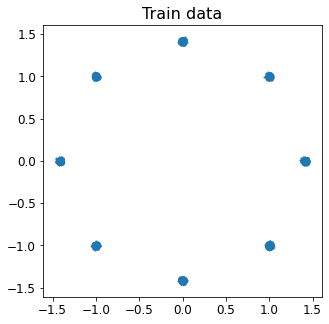

In [20]:
COUNT = 20000

train_data = generate_2d_data(COUNT)
visualize_2d_samples(train_data, "Train data")

We will use the following helper functions. Please, read them carefully!

In [21]:
def make_inference(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    xs = np.linspace(-3.0, 3.0, 1000 + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.concatenate((xg.reshape(-1, 1), yg.reshape(-1, 1)), axis=-1)
    
    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().detach().numpy()
        critic_output = critic(torch.FloatTensor(grid).cuda()).cpu().detach().numpy()
    
    critic_output = np.prod(critic_output, axis=-1).reshape((1000 + 1, 1000 + 1))
    return samples, grid, critic_output


def visualize_critic_output(generated_samples, real_samples, grid, critic_output, npts=100 + 1):
    plt.figure(figsize=(6, 6))
    plt.gca().set_aspect("equal")
    
    npts = critic_output.shape[0]
    cnt = plt.contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_output,
        levels=25, cmap="cividis"
    )
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5)
    plt.scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5)
    plt.colorbar(cnt)

## WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Here $f(\mathbf{x}, \boldsymbol{\phi})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In this task we will use fully-connected networks for the generator $G(\mathbf{z}, \boldsymbol{\theta})$ and the critic $f(\mathbf{x}, \boldsymbol{\phi})$.

In [22]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_dim, hiddens, output_dim):
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.hiddens    = hiddens
        
        model = list()
        # ====
        # your code
        # stack Linear layear and ReLU (the last layer shoud be Linear)
        model.extend( [ nn.Linear(self.input_dim, self.hiddens[0]), nn.ReLU() ] )
        for i in range( len(self.hiddens)-1 ):
            model.extend( [ nn.Linear(self.hiddens[i + 0], self.hiddens[i + 1]), nn.ReLU() ] )
        model.extend( [ nn.Linear(self.hiddens[-1], self.output_dim) ] )
        self.net = nn.Sequential(*model)
        # ====

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, self.output_dim)

Let define the generator and critic networks. 

We only need to define 
1. the sample method for the generator;
2. weight clipping for the critic.

In [23]:
class MLPGenerator(FullyConnectedMLP):
    def sample(self, n):
        # ====
        # your code
        # 1) sample from standard normal distribution 
        # 2) apply the model
        loc   = torch.zeros(self.input_dim)
        scale = torch.ones (self.input_dim)
        sample_s = torch.distributions.Normal(loc, scale).sample((n,))
        
        if USE_CUDA :
            sample_s = sample_s.cuda()
        
        return self.net.forward(sample_s)
        # ====

In [24]:
class MLPCritic(FullyConnectedMLP):
    def clip_weights(self, c):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                # ====
                # your code
                # clip the weight to the range [-c, c]
                layer.weight = nn.Parameter(torch.clamp( layer.weight, min=-c, max=c ))
                # ====
                
                

Now we need to implement the train loop.

In [25]:
def train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs,
    lr, 
    clip_c,
    use_cuda
):
    train_losses = []

    if use_cuda:
        generator = generator.cuda()
        critic = critic.cuda()

    gen_optimizer    = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic   .parameters(), lr=lr, betas=(0, 0.9))

    generator.train()
    critic.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}
    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, x) in enumerate(train_loader):
            curr_iter += 1
            if use_cuda:
                x = x.cuda()

            # do a critic update
            with torch.no_grad():
                fake_data = generator.sample(x.shape[0])
            
            critic_optimizer.zero_grad()
            # ====
            # your code
            # D(x_fake) - D(x_real)
            d_loss = critic(fake_data).mean() - critic(x).mean()
            # ====
            
            d_loss.backward()
            critic_optimizer.step()
            critic.clip_weights(clip_c)

            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                
                # ====
                # your code
                # -D(x_fake)
                g_loss = -critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

    return batch_loss_history

  0%|          | 0/300 [00:00<?, ?it/s]

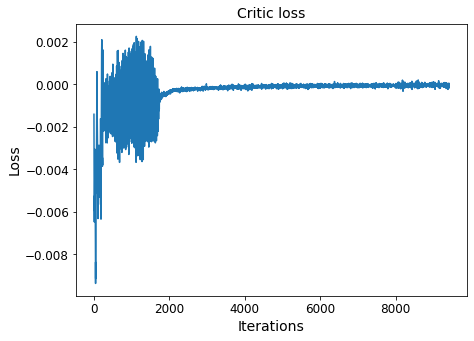

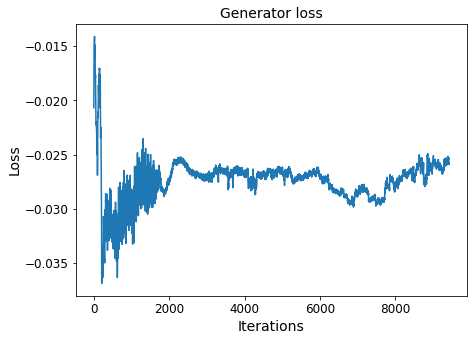

In [49]:
# ====
# your code
# choose these parameters
BATCH_SIZE    = 128                # any adequate value
GEN_HIDDENS   = [64, 64, 64, 64] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 64, 64, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS  = 5     # > 2
LR            = 5.e-4 # < 1e-2
CLIP_C        = 0.1   # < 1
# ====

N_EPOCHS = 300 # 200 change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(input_dim=16, hiddens=GEN_HIDDENS  , output_dim=2)
critic    = MLPCritic   (input_dim=2 , hiddens=DISCR_HIDDENS, output_dim=1)

train_losses_1 = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    use_cuda=USE_CUDA
)

plot_losses(train_losses_1['discriminator_losses'], 'Critic loss'   )
plot_losses(train_losses_1['generator_losses'    ], 'Generator loss')

#train_losses_2 = train_wgan(
#    generator, 
#    critic, 
#    train_loader,
#    critic_steps=CRITIC_STEPS, 
#    batch_size=BATCH_SIZE, 
#    n_epochs=N_EPOCHS,
#    lr=1.e-4,
#    clip_c=CLIP_C,
#    use_cuda=USE_CUDA
#)
#
#plot_losses(train_losses_2['discriminator_losses'], 'Critic loss')
#plot_losses(train_losses_2['generator_losses'], 'Generator loss')

Let plot the results.

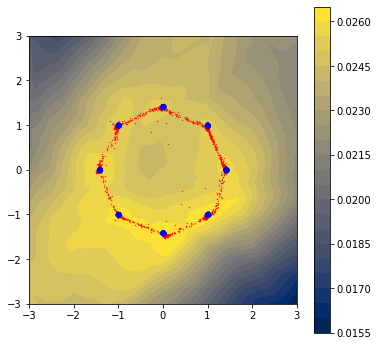

In [50]:
samples, grid, critic_output = make_inference(generator, critic)
visualize_critic_output(samples, train_data, grid, critic_output)

## WGAN-GP

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}_t} f(\hat{\mathbf{x}}_t) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

Let define our gradient penalty loss.

In [23]:
from torch.distributions.uniform import Uniform
from torch.linalg                import norm

d = Uniform(torch.tensor([0.0]), torch.tensor([1.0]))

def gradient_penalty(critic, real_data, fake_data, use_cuda=False):
    batch_size = real_data.shape[0]

    # ====
    # your code
    # Calculate interpolation x_t = t * x_real + (1 - t) x_fake
    # 1) sample t
    # 2) create x_t (be careful about shapes)
    # 3) apply critic to x_t
    t = d.sample()
    
    if use_cuda:
        t = t.cuda()
    
    x = t * real_data + (1-t) * fake_data
    output = critic(x)
    # ====

    gradients = torch.autograd.grad(
        outputs=output, 
        inputs=x, 
        grad_outputs=torch.ones(output.size()).to(fake_data.device), 
        create_graph=True, 
        retain_graph=True
    )[0]

    gradients = gradients.reshape(batch_size, -1)
    # ====
    # your code
    # compute gradient norm
    gradients_norm = norm(gradients, dim=1)
    # ====
    return ((gradients_norm - 1) ** 2).mean()


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x ** 2))
    x = torch.randn(size=(10, 4))
    x.requires_grad = True
    assert gradient_penalty(lambda x: x, x, x).numpy() == 1
    assert gradient_penalty(lambda x: x * 0, x, x).numpy() == 1


test_gradient_penalty()

Our training loop is similar to the previous one, but here we will 
use the gradient penalty instead of weight clipping.

In [9]:
def train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs,
    lr, 
    gp_weight=10,
    use_cuda=False
):

    if use_cuda:
        critic = critic.cuda()
        generator = generator.cuda()
    critic.train()
    generator.train()

    gen_optimizer    = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}
    for epoch_i in tqdm(range(n_epochs)):
        for batch_i, x in enumerate(train_loader):
            curr_iter += 1
            if use_cuda:
                x = x.cuda()

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])

            # ====
            # your code
            # D(x_fake) - D(x_real) + gp_weight * grad_pen
            grad_pen = gradient_penalty(critic, x, fake_data, use_cuda)
            if use_cuda :
                grad_pen = grad_pen.cuda()
            d_loss = critic(fake_data).mean() - critic(x).mean() + gp_weight*grad_pen
            # ====

            d_loss.backward()
            critic_optimizer.step()
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # ====
                # your code
                # -D(x_fake)
                g_loss = -critic(fake_data).mean()
                # ====
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

    return batch_loss_history

  0%|          | 0/300 [00:00<?, ?it/s]

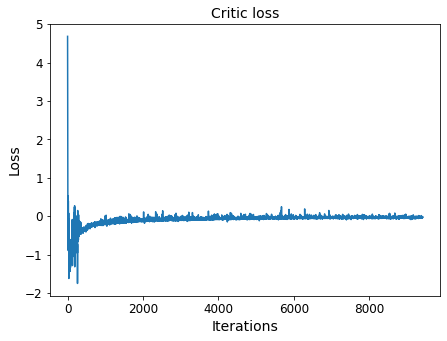

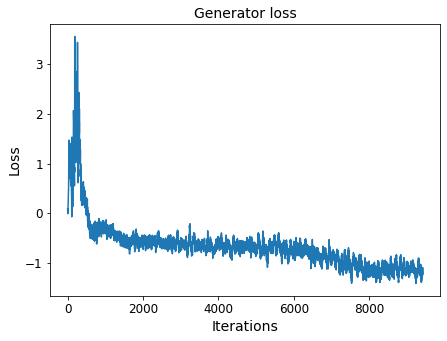

In [64]:
# ====
# your code
# choose these parameters
BATCH_SIZE    = 128    # any adequate value
GEN_HIDDENS   = [64, 64, 64, 64] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 64, 64, 64] # 4 layers with < 128 neurons would be enough 
CRITIC_STEPS  = 5     # > 2
LR            = 5.e-4 # < 1e-2
GP_WEIGHT     = 5     # > 5
# ====

N_EPOCHS = 300
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(input_dim=16, hiddens=GEN_HIDDENS, output_dim=2)
critic = MLPCritic(input_dim=2, hiddens=DISCR_HIDDENS, output_dim=1)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    use_cuda=USE_CUDA
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

Let plot the results.

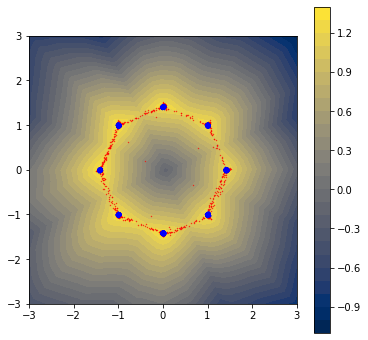

In [65]:
samples, grid, critic_output = make_inference(generator, critic)
visualize_critic_output(samples, train_data, grid, critic_output)

# Task 3: WGAN-GP for CIFAR 10 (5pt)

In this task you will fit [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with [Gradient Penalty](https://arxiv.org/pdf/1704.00028.pdf) model to the CIFAR10 dataset.

Download the data from [here](https://drive.google.com/file/d/16j3nrJV821VOkkuRz7aYam8TyIXLnNme/view?usp=sharing) (you could use the cell below).

In [ ]:
#!gdown --id 16j3nrJV821VOkkuRz7aYam8TyIXLnNme

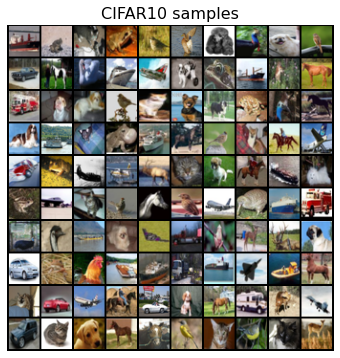

In [4]:
train_data, test_data = load_pickle('cifar10.pkl')
visualize_images(train_data, 'CIFAR10 samples')

Here we will use convolution-based generator and critic.

First of all, let define generator network.

In [27]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size=128, n_channels=64):
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        # ====
        # your code
        # you could you this architecture or your own
        # 1) define linear layer with output units 4 * 4 * 4 * n_channels, then relu
        # 2) define transposed conv with stride 2, kernel size 2 then BN, then relu
        # 3) define transposed conv with stride 2, kernel size 2 then BN, then relu
        self.linear_1 = nn.Linear     (self.input_size, 4 * 4 * 4*self.n_channels)
        self.bn_1     = nn.BatchNorm2d(4*self.n_channels)
        
        self.conv_t_2 = nn.ConvTranspose2d(4*self.n_channels, 2*self.n_channels, 2, stride=2)
        self.bn_2     = nn.BatchNorm2d    (2*self.n_channels)
        self.conv_t_3 = nn.ConvTranspose2d(2*self.n_channels, 1*self.n_channels, 2, stride=2)
        self.bn_3     = nn.BatchNorm2d    (1*self.n_channels)
        
        self.conv_t_4 = nn.ConvTranspose2d(1*self.n_channels, 3, 2, stride=2)
                
        self.func = nn.ReLU()
        # ====

    def forward(self, x):
        # ====
        # your code
        # 1) apply all layers
        # 2) the output should be in the range of [0, 1] (apply activation) 
        x = self.linear_1(x); x = x.view(-1, 4 * self.n_channels, 4, 4)
        x = self.bn_1    (x)
        x = self.func    (x)
        
        x = self.conv_t_2(x)
        x = self.bn_2    (x)
        x = self.func    (x)
        
        x = self.conv_t_3(x)
        x = self.bn_3    (x)
        x = self.func    (x)
        
        x = self.conv_t_4(x)
        y = (torch.tanh  (x) + 1)/2
        
        # ====
        return y.view(-1, 3, 32, 32)

    def sample(self, n_samples):
        # ====
        # your code
        # sample from standard normal distribution and apply the model
        loc   = torch.zeros(self.input_size)
        scale = torch.ones (self.input_size)
        p     = torch.distributions.Normal(loc, scale)
        
        x_s = p.sample_n(n_samples)
        
        if USE_CUDA:
            x_s = x_s.cuda()
        
        return self.forward(x_s)
        # ====

Now it is time to define our critic.

In [28]:
class ConvCritic(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        
        # ====
        # your code
        # sequence of Conv2D with kernel size 3 stride 2 and LeakyRelU
        self.conv_1   = nn.Conv2d(3                , 1*self.n_channels, 5, stride=2)
        self.conv_2   = nn.Conv2d(1*self.n_channels, 2*self.n_channels, 5, stride=2)
        self.conv_3   = nn.Conv2d(2*self.n_channels, 4*self.n_channels, 5, stride=2)
        self.linear_4 = nn.Linear(4*4*4*self.n_channels, 1)
        
        self.func     = nn.LeakyReLU()
        # ====

    def forward(self, x):
        # ====
        # your code
        # apply all layers
        x = self.conv_1(x)
        x = self.func  (x)
        x = self.conv_2(x)
        x = self.func  (x)
        x = self.conv_3(x)
        x = self.func  (x)
        
        x = x.view(-1, 4*4*4*self.n_channels)
        y = self.linear_4(x)
        # ====
        return y

That is all :) We will use the train loop from the previous task here.

  0%|          | 0/20 [00:00<?, ?it/s]

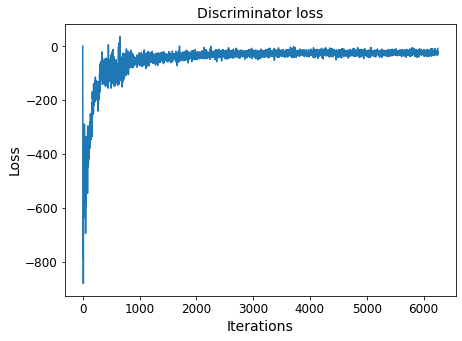

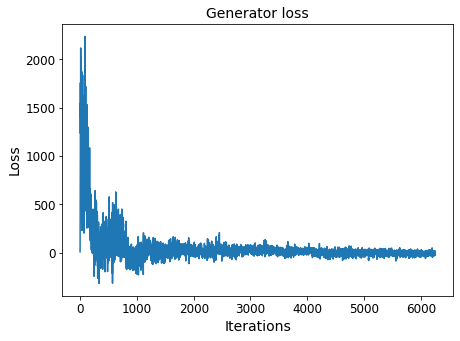

In [29]:
# ====
# your code
# choose these parameters (you have to train the model more than 20 epochs to get good results)
BATCH_SIZE   = 32   # any adequate value
N_CHANNELS   = 64   # > 32
N_EPOCHS     = 20   # > 10
CRITIC_STEPS = 5    # > 2
GP_WEIGHT    = 5    # > 5
LR           = 5e-4 # < 1e-3
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = ConvGenerator(n_channels=N_CHANNELS)
critic    = ConvCritic   (n_channels=N_CHANNELS)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    use_cuda=USE_CUDA
)

plot_losses(train_losses['discriminator_losses'], 'Discriminator loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

Let sample from our model and draw the samples.

/home/sergey/python-virtual-environments/ErlyVideo/lib/python3.8/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


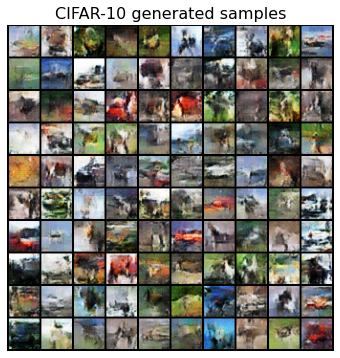

In [30]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.cpu().detach().numpy()
    

show_samples(samples[:100], title='CIFAR-10 generated samples')